## FFT

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from darts import TimeSeries
from darts.models import (
    FFT,
    AutoARIMA,
    ExponentialSmoothing,
    Prophet,
    Theta
)
from darts.metrics import mape
from darts.utils.missing_values import fill_missing_values

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('../data/temps.csv')
df['temps'] = df['Daily minimum temperatures'].str.replace('^[^\d]*', '').astype(float)
df.head()

,Date,Daily minimum temperatures,temps
0,1/1/1981,20.7,20.7
1,1/2/1981,17.9,17.9
2,1/3/1981,18.8,18.8
3,1/4/1981,14.6,14.6
4,1/5/1981,15.8,15.8


#### Constructing TimeSeries instances for training and validation

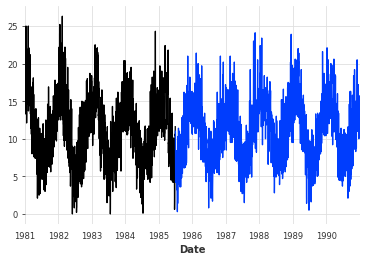

In [3]:
ts = fill_missing_values(TimeSeries.from_dataframe(df, 'Date', ['temps']), 'auto')
train, val = ts.split_after(pd.Timestamp('19850701'))
train.plot()
val.plot()

#### Basic FFT model

In [4]:
model = FFT(required_matches=set(), nr_freqs_to_keep=None)
model.fit(train)
pred_val = model.predict(len(val))

MAPE: 416130884490747.6


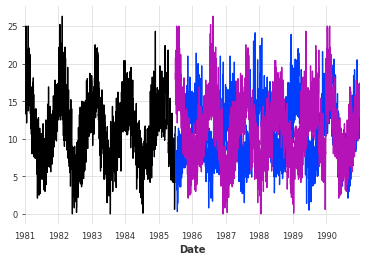

In [5]:
train.plot()
val.plot()
pred_val.plot()
print("MAPE:", mape(pred_val, val))

#### Improvement 1: Crop the training set

In [6]:
model = FFT(nr_freqs_to_keep=None)
model.fit(train)
pred_val = model.predict(len(val))

MAPE: 300841486646235.06


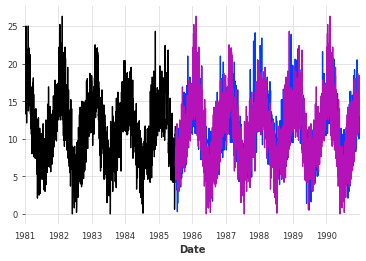

In [7]:
train.plot()
val.plot()
pred_val.plot()
print("MAPE:", mape(pred_val, val))

#### Improvement 2: Filtering out low-amplitude waves

In [8]:
model = FFT(nr_freqs_to_keep=20)
model.fit(train)
pred_val = model.predict(len(val))

MAPE: 23.280281955513267


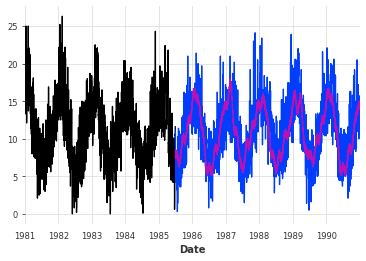

In [9]:
train.plot()
val.plot()
pred_val.plot()
print("MAPE:", mape(pred_val, val))

#### Improvement 3: Detrending

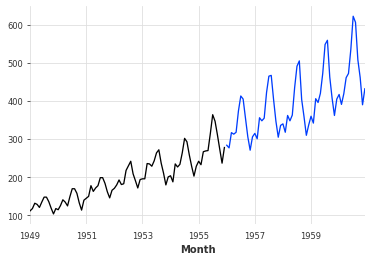

In [10]:
df = pd.read_csv('../data/AirPassengers.csv', delimiter=",")
ts_2 = TimeSeries.from_dataframe(df, 'Month', ['#Passengers'])
train, val = ts_2.split_after(pd.Timestamp('19551201'))
train.plot()
val.plot()

In [11]:
model = FFT()
model.fit(train)
pred_val = model.predict(len(val))

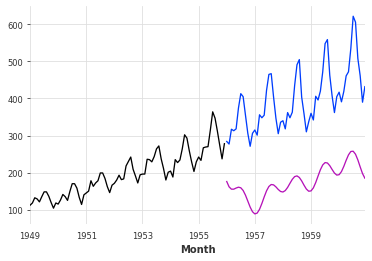

In [12]:
train.plot()
val.plot()
pred_val.plot()

In [13]:
model = FFT(trend='poly')
model.fit(train)
pred_val = model.predict(len(val))

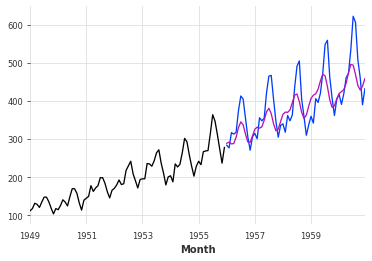

In [14]:
train.plot()
val.plot()
pred_val.plot()

#### New Data: Hourly Nuclear Energy Generation

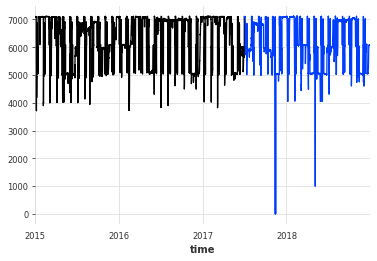

In [15]:
df = pd.read_csv('../data/energy_dataset.csv', delimiter=",")
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time']= df.time.dt.tz_localize(None)

ts_3 = TimeSeries.from_dataframe(df, 'time', ['generation nuclear'])
ts_3 = fill_missing_values(ts_3, 'auto')
train, val = ts_3.split_after(pd.Timestamp('2017-07-01'))
train.plot()
val.plot()

In [16]:
%%time
models = [
    AutoARIMA(),
    Prophet(),
    ExponentialSmoothing(),
    Theta(),
    FFT()
]

for model in models:
    model.fit(train)
    pred_val = model.predict(len(val))
    print(str(model) + " MAPE: " + str(mape(pred_val, val)))

Auto-ARIMA MAPE: 13.46753956256134
Prophet MAPE: 10.852517565060243
Exponential smoothing MAPE: 17.849425318793447
Theta(2) MAPE: 13.330007725418852
FFT(nr_freqs_to_keep=10, trend=None) MAPE: 10.263184839655274
CPU times: user 11min 34s, sys: 1min 29s, total: 13min 3s
Wall time: 14min 35s
